L'objectif de ce projet est de créer un modèle de classification d'images de chiens selon leur race. La base d'images est constitué de photos de 120 races de chien avec en moyenne 170 photos par race.

Nous utilisons pour cela des réseaux de neurones convolutifs (CNN). Dans une première partie nous réalisons du Transfer Learning en modifiant uniquement la dernière couche de classification de nos CNN. Ceci avec les CNN ResNet50 et VGG16 préentrainés avec la base d'images "Imagenet", d'abord sur 10 races de chien puis sur les 120.

Dans une seconde partie, nous créons notre propre CNN dont l'architecture est inspirée de VGG16. Nous nous limitons à 10 races uniquement.

Pour ce projet nous utilisons la bibliothèque Keras de Tensorflow.

# Importations et options d'affichage du dataframe

In [2]:
import math
import numpy as np
import pandas as pd
import time
import re
import os.path
import datetime
import pickle
now = datetime.datetime.now # Pour les tps de calcul


# Gestion des figures :
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib import colors
sns.set()

In [3]:
# Paramètres d'affichage des dataframes :

pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)
pd.set_option('precision', 4)
pd.set_option('max_colwidth', 100)
pd.set_option('column_space', 12)

In [6]:
# Chemin d'importation des données :
chemin = '/images/'
chemin2 = '/images/Fichiers/'


In [7]:
from PIL import Image

In [8]:
# Bout de code pour renommer les dossiers :

# p = re.compile('-+[a-zA-z-]*')

# for name in os.listdir(chemin + 'Images/'):
#     os.rename(chemin + 'Images/' + name, chemin + 'Images/' + p.findall(name)[0][1:])
 
#  for name in os.listdir(chemin + 'Annotation/'):
#     os.rename(chemin + 'Annotation/' + name, chemin + 'Annotation/' + p.findall(name)[0][1:])

# I - Fonctions de prédiction, métriques

Cette partie contient les fonctions utiles pour afficher les prédictions d'un modèle, les erreurs de prédiction, la matrice des erreurs, etc...

In [9]:
from sklearn.metrics import accuracy_score

In [ ]:

# def prediction(model, y_pred_proba):
#     y_pred = decode_predictions(y_pred_proba, top=1)
#     return [y[0][1] for y in y_pred]

In [ ]:
import matplotlib.colors as mcolors
from matplotlib import cm


# Fonction qui affiche l'accuracy par label

def accuracy_par_label(y_true, y_pred, dict_labels):
    # on reverse le dictionnaire des labels :
    dict_labels = {v:k for (k,v) in dict_labels.items()}

    df = pd.DataFrame(y_true, columns=['y_true'])
    df['y_pred'] = y_pred
    
    df_results = pd.DataFrame(index=df.y_true.unique())
    df_results['index_copy'] = df_results.index
    # for label in liste_labels:
    #     mask = df.y_true == labels
    #     score = accuracy_score(df[mask].y_true, df[mask].y_pred)
    
    df_results['accuracy'] = df_results.index_copy.apply(lambda label : mask_accuracy(df, label))
    df_results['label'] = df_results.index_copy.apply(lambda k : dict_labels[k])
    df_results.set_index('label', inplace=True)

    plt.figure(figsize = (14,len(dict_labels)/5 + 4))
    
    serie = df_results['accuracy'].sort_values(ascending=True)    
    serie.plot(kind='barh', color = cm.RdYlGn(serie))
    
    plt.title('Accuracy par race de chien sur les données de test\nAccuracy globale = {:.2f} %'.format(100*accuracy_score(y_true, y_pred)), size=16)
    plt.xlabel('Accuracy')
    return df_results

# Petite fonction pour le apply :
def mask_accuracy(df, label):
    mask = df.y_true == label
    return accuracy_score(df[mask].y_true, df[mask].y_pred)



In [ ]:
# Fonction qui affiche les erreurs de prédiction pour chaque image : l'image pour laquelle la prédiction est fausse est titrée par le vrai label et le label prédit.
# n_images = nombre d'images à afficher


def affichage_predict_errors(y_true, y_pred, dict_labels, filepaths, n_images=10):
    # on reverse le dictionnaire des labels :
    dict_labels = {v:k for (k,v) in dict_labels.items()}
    list_indices = [] 
    true_labels = []
    wrong_labels = []

    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            list_indices.append(i)
            true_labels.append(dict_labels[y_true[i]])
            wrong_labels.append(dict_labels[y_pred[i]])
    # Nombre de fausses predictions
    n, m = len(list_indices), len(y_true)
    print('{} erreurs de prédiction sur {} (Accuracy = {:.2f} %)'.format(n, m, 100*(m-n)/m))


    fig, ax = plt.subplots(1, n_images, figsize = (9*n_images,6))

    for i, j  in enumerate(list_indices[:n_images]):
        img = Image.open(filepaths[j])
        ax[i].imshow(img)
        ax[i].set_title('Race réelle = {}, race prédite = {}'.format(true_labels[i], wrong_labels[i]))
        ax[i].axis('off')


    plt.show()

In [ ]:
# La fonction suivante retourne la matrice des erreurs de prédiction.
# L'option display=True permet d'afficher la matrice avec une heatmap

def matrix_errors(y_true, y_pred, dict_labels, display=True, aff_infos=True):
    # on reverse le dictionnaire des labels :
    labels = list(dict_labels.keys())
    dict_labels = {v:k for (k,v) in dict_labels.items()}
    n_labels = len(labels)

    # Calcul de la matrice :
    matrix = np.zeros([n_labels, n_labels])
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            matrix[y_true[i], y_pred[i]] += 1

    if display == True:
        fig = plt.figure(figsize=(n_labels/1.5,n_labels/1.5))

        # Heatmap
        ax = sns.heatmap(matrix, vmin=0, vmax=matrix.max(),
                        cmap=sns.light_palette("g", as_cmap=True),
                        square=True,
                        xticklabels=[], 
                        yticklabels=labels,
                        cbar=False)

        # affichage des labels
        for j, label in enumerate(labels):
            plt.text(j+0.3, -0.2, label, rotation=45)

        # Affichage des coefficients :
        if aff_infos:
            for j in range(n_labels):
                for i in range(n_labels):
                    plt.text(j+0.4,i+0.6, '{}'.format(int(matrix[i,j])))

        plt.show()
    return matrix


In [ ]:
# Fonction qui renvoie les erreurs pour une race donnée sous la forme d'un dictionnaire,
# en utilisant la matrice retournée par la fonction précédente (passée en paramètre).

def erreur_par_race(matrix, race, dict_labels):
    labels = list(dict_labels.keys())
    i = labels.index(race)
    dict_errors = {}
    for j in range(len(labels)):
        if matrix[i,j] > 0:
            dict_errors[labels[j]] = int(matrix[i,j])

    print('Erreurs', race, ':', dict_errors)


# II - Fonctions de Préprocessing

La plupart des fonctions de preprocessing des images que nous utilisons dans ce notebook sont des filtres de la librairie PIL. On peut voir l'effet de ces filtres dans le notebook de visualisations des preprocessings.

In [ ]:
# Fonction d'égalisation :
# La fonction prend en entrée une image "numpy" et retourne une image "numpy"

def img_equalize(img):
    img = array_to_img(img)
    img = ImageOps.equalize(img)
    return img_to_array(img)

In [ ]:
from PIL import ImageFilter
from keras.preprocessing.image import array_to_img, img_to_array

# Petite fonction qui retourne une fonction correspondant à un filtre d'image et que l'on peut directement passer à l'argument preprocessing_function
# du data_generator de keras.

def preprocessing_filter(filtre):
    return lambda img: img_to_array(array_to_img(img).filter(filtre))

Using TensorFlow backend.


# III - Transfer Learning

Nous allons effectuer du transfert learning sur le CNN Resnet50, pour commencer nous allons nous restreindre au 10 premières races de chien (par ordre alphabétique). Après avoir effectué quelques améliorations du modèle, nous généraliserons le modèle sur l'ensemble des 120 races de chien.

Pour tout le transfer learning nous allons utiliser la fonction de preprocessing fournie par keras.  
On a testé d'autres fonctions de preprocessing mais elles donnent globalement de moins bons résultats.



## A - Transfer learning sur Resnet 50 

In [ ]:
# On aurait pu utiliser aussi resnet50 v2

from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

### Premier modèle

#### ImageDataGenerator avec les images non recadrées et sans data augmentation

Pour charger les images d'entrainement et de test, nous utilisons la classe ImageDataGenerator de Keras. Il suffit de stocker les photos de chaque classe dans un dossier, et le Datagenerator fait tout le boulot : séparation des images d'entrainement et de test, preprocessing des images grâce à une fonction passée en argument, data-augmentation, etc...

In [ ]:
image_size = 224
directory = chemin + 'Images_selection'

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)


train_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=1000,  # max
        class_mode='categorical',
        shuffle=False,
        subset='validation')


Found 1484 images belonging to 10 classes.
Found 366 images belonging to 10 classes.


#### Modèle

Pour débuter nous utilisons le CNN Resnet50 pré-entrainé avec la collection 'imagenet'. Nous ajoutons simplement une couche fully-connected de classification, qui nous donne une distribution de probabilités pour une image passée dans le réseau grâce à la fonction softmax. La fonction de perte utilisée pour mettre à jour les poids du réseau est l'entropie croisée, et l'optimiser utilisé est le SDG utilisé avec les paramètres standards (learning_rate = 0.01). Pour évaluer les performances du modèle on utilise l'accuracy. 

In [ ]:
ResNet50().summary()

102858752/102853048 [==============================] - 7s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
________________________

In [ ]:
num_classes = 10

model_1 = Sequential()
model_1.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model_1.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
model_1.layers[0].trainable = False


model_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()


94658560/94653016 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Checkpoint pour sauvegarder le modèle à la fin de chaque époque :

checkpoint_filepath = chemin2 + 'checkpoint_1'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            save_best_only=True)

In [ ]:
# Entrainement du modèle :

# On sauvegarde les poids du modèle entrainé grâce au checkpoint.
# En option on peut charger les poids précédemment enregistrés.
# Si on ne recalcule pas le modèle, on utilise les prédictions qui ont été précédemment sauvegardées.

recompute_model_1 = False
Load_weights = False

if recompute_model_1:

    if Load_weights:
        model_1.load_weights(checkpoint_filepath)

    # Model fit, on récupère l'historique :
    fit_history  = model_1.fit_generator(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=1,
            callbacks=[model_checkpoint_callback])

    History_1 = fit_history.history

    validation_generator.reset()
    pred = model_1.predict_generator(validation_generator, verbose = 1)
    y_true = np.argmax(validation_generator[0][1], axis=1)
    y_pred_1 = np.argmax(pred, axis = 1)
    
    model_results = (History_1, y_true, y_pred_1)

    # Sauvegarde des résultats
    with open(chemin2 + 'model_1_results', 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(model_results)

# Si on ne recalcule pas le modèle on charge directement les résultats :
else:
    with open(chemin2 + 'model_1_results', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History_1, y_true, y_pred_1) = mon_depickler.load()


# Résultats et essais :

# cropping + preprocess resnet50 --> 94 %

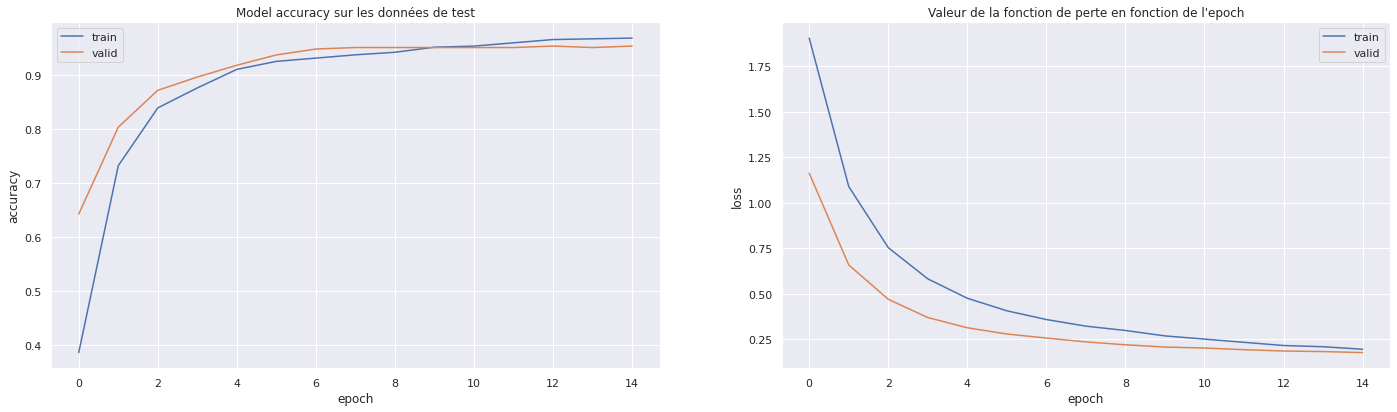

In [ ]:
# Accuracy et fonction de perte, en fonction de l'epoch

plt.figure(figsize = (24,14)) 

# Accuracy : 
plt.subplot(221)  
plt.plot(History_1['accuracy'])
plt.plot(History_1['val_accuracy'])  
plt.title('Model accuracy sur les données de test')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

# Fonction de perte :
plt.subplot(222)  
plt.plot(History_1['loss'])  
plt.plot(History_1['val_loss'])  
plt.title('Valeur de la fonction de perte en fonction de l\'epoch')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

#### Accuracy par race et affichage des erreurs

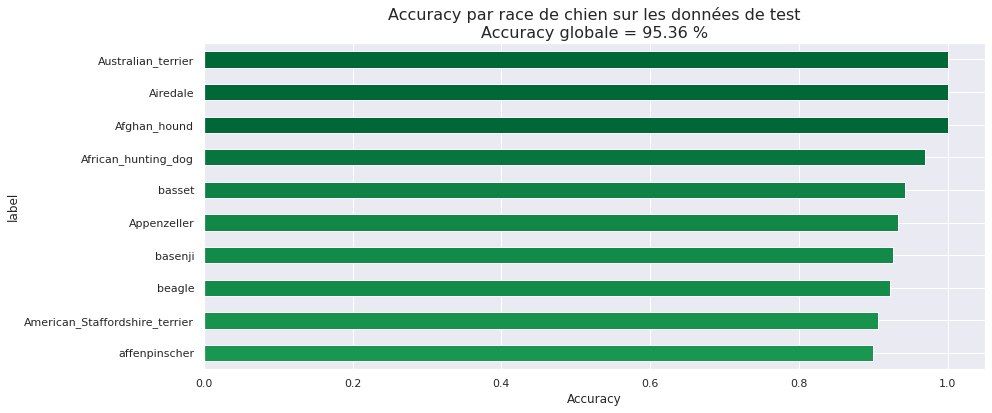

In [ ]:
df_results = accuracy_par_label(y_true, y_pred_1, dict_labels=validation_generator.class_indices)

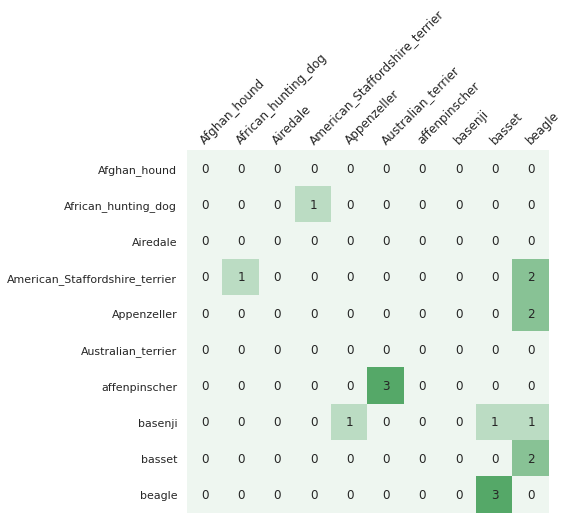

In [ ]:
# En abscisse les catégories réelles, en ordonnée les catégories prédites : 
matrix_errors(y_true, y_pred_1, validation_generator.class_indices)
print()

In [ ]:
affichage_predict_errors(y_true, y_pred_1, validation_generator.class_indices, validation_generator.filepaths, 17)

### Amélioration du Modèle

Dans cette partie on teste différentes modifications / améliorations du modèle précédent : 

*   On recadre les images grâce aux fichiers XML.
*   On a testé différents choix de data-augmentation.
*   On a testé l'ajout d'une couche fully-connected avant la dernière couche de classification.
*   On a testé d'autres Optimizers (Adam, Rmsprop), avec éventuellement différents paramètres.
*   On a testé le réentrainement de toutes les couches.

Tous ces changements n'améliorent pas nécessairement les performances du modèles initial, pour lequel l'accuracy est déjà très bonne (> 95%).  
Ces changement se révéleront plus utiles pour la construction de notre propre CNN.




#### ImageDataGenerator avec cropping

In [ ]:
directory = chemin + 'Images_selection_crop'

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)


data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    validation_split=0.2,
                                    rotation_range=20,
                                    #width_shift_range=0.2,
                                    #height_shift_range=0.2,
                                    horizontal_flip=True,
                                    #vertical_flip=True,
                                    #zoom_range=0.5,
                                    #channel_shift_range=50,
                                    )

train_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,  # max
        class_mode='categorical',
        shuffle=False,
        subset='validation')



Found 1484 images belonging to 10 classes.
Found 366 images belonging to 10 classes.


#### Modèle

In [ ]:
num_classes = 10

model_2 = Sequential()
model_2.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
#model_2.add(Dense(1024, activation='relu'))
model_2.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
model_2.layers[0].trainable = False


model_2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Checkpoint pour sauvegarder le modèle à la fin de chaque époque :

checkpoint_filepath_2 = chemin2 + 'checkpoint_2'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath_2,
                                            save_weights_only=False,
                                            save_best_only=True)

In [ ]:
recompute_model_2 = False
Load_weights = False

if recompute_model_2:

    if Load_weights:
        model_2.load_weights(checkpoint_filepath_2)

    # Model fit :
    fit_history  = model_2.fit_generator(
            train_generator,
            epochs=10,
            # steps_per_epoch=10, # ajusté automatiquement en fct du batch_size et du nb d'images dans le train 
            validation_data=validation_generator,
            verbose=1,
            callbacks=[model_checkpoint_callback])

    # Save (history, y_true, y_pred) sur les données de validation :
    History_2 = fit_history.history
    
    validation_generator.reset()
    pred = model_2.predict_generator(validation_generator, verbose = 1)
    y_pred_2 = np.argmax(pred, axis = 1)
    
    y_true_f = []
    for i in range(len(validation_generator)):
        y_true_f += list(np.argmax(validation_generator[i][1], axis=1))

    model_results = (History_2, y_true, y_pred_2)

    with open(chemin2 + 'model_2_results', 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(model_results)

else:
    with open(chemin2 + 'model_2_results', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History_2, y_true, y_pred_2) = mon_depickler.load()


# Remarques : 

# l'ajout d'une couche fully connected en avant dernière couche n'améliore pas grand chose
# Idem pour la data augmentation...
# Le réentrainement de toutes les couches fait baisser la loss_train plus rapidement
# Il semble qu'on atteigne un plafond de verre à 95%...


#### Accuracy par race et affichage des erreurs

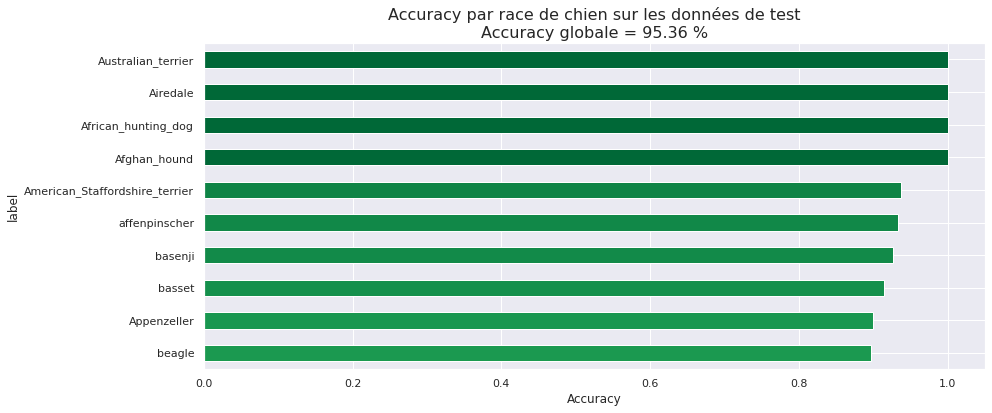

In [ ]:
df_results = accuracy_par_label(y_true, y_pred_2, dict_labels=validation_generator.class_indices)


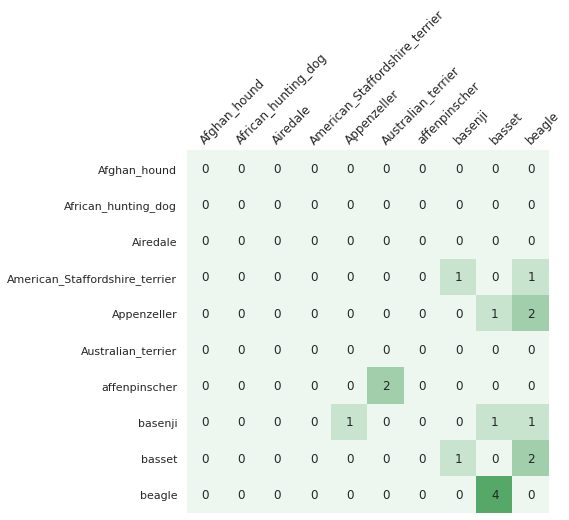

In [ ]:
matrix_errors(y_true, y_pred_2, validation_generator.class_indices)
print()

In [ ]:
#affichage_predict_errors(y_true, y_pred_2, validation_generator.class_indices, validation_generator.filepaths)

## B - Transfer learning sur VGG16

Dans cette partie, on procède comme précédemment mais avec le modèle VGG16 à la place de Resnet50.

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16, decode_predictions


### ImageDataGenerator

In [ ]:
# On utilise les images recadrées :
directory = chemin + 'Images_selection_crop'
image_size = 224

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    validation_split=0.2,
                                    #rotation_range=20,
                                    #horizontal_flip=True,
                                    )

train_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=50,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=50,
        class_mode='categorical',
        shuffle=False,
        subset='validation')

Found 1484 images belonging to 10 classes.
Found 366 images belonging to 10 classes.


### Modèle

In [ ]:
#VGG16().summary()

In [ ]:
num_classes = 10

model_VGG16 = Sequential()
model_VGG16.add(VGG16(include_top=False, pooling='avg', weights='imagenet'))
model_VGG16.add(Dense(1024, activation='relu'))
model_VGG16.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer model. It is already trained
model_VGG16.layers[0].trainable = False


model_VGG16.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model_VGG16.summary()


58892288/58889256 [==============================] - 5s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                10250     
Total params: 15,250,250
Trainable params: 535,562
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
checkpoint_filepath_3 = chemin2 + 'checkpoint_3'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath_3,
                                            save_weights_only=False,
                                            save_best_only=True)

In [ ]:
recompute_model_VGG16 = False
Load_weights = False

if recompute_model_VGG16:
    if Load_weights:
        model_VGG16.load_weights(checkpoint_filepath_3)

    # Model fit :
    fit_history  = model_VGG16.fit_generator(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=1)

    # Save (history, y_true, y_pred) sur les données de validation :
    History_3 = fit_history.history
    
    validation_generator.reset()
    pred = model_VGG16.predict_generator(validation_generator, verbose = 1)
    y_pred = np.argmax(pred, axis = 1)

    y_true = []
    for i in range(len(validation_generator)):
        y_true += list(np.argmax(validation_generator[i][1], axis=1))    

    model_results = (History_3, y_true, y_pred)

    with open(chemin2 + 'model_VGG16_results', 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(model_results)

else:
    with open(chemin2 + 'model_VGG16_results', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History_3, y_true, y_pred) = mon_depickler.load()


# Impossible de réentrainer toutes les couches la fonction de perte diverge
# L'avant dernière couche fully-connected semble être un plus (on reste à 90% sans)
# Là aussi la data augmentation ne semble pas utile !

### Accuracy par race et affichage des erreurs

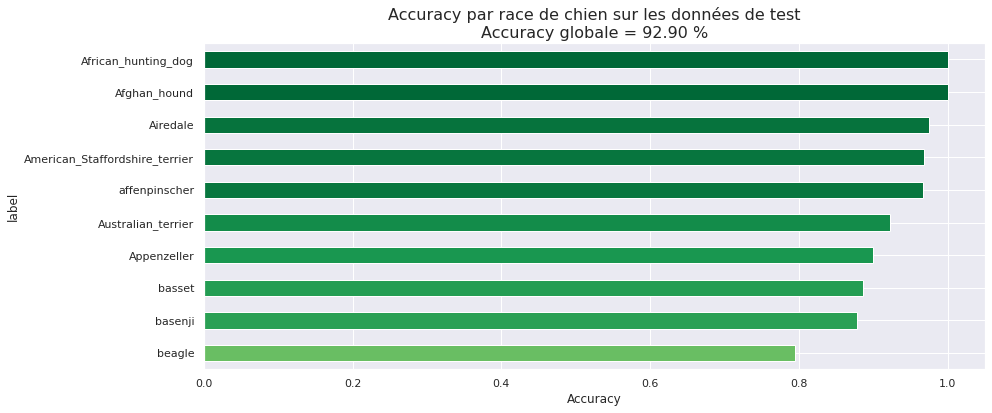

In [ ]:
df_results = accuracy_par_label(y_true, y_pred, dict_labels=validation_generator.class_indices)


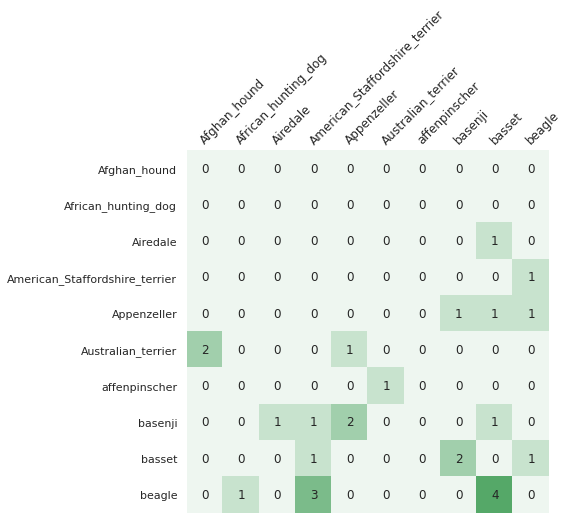

In [ ]:
matrix_errors(y_true, y_pred, validation_generator.class_indices)
print()

## C - Modèle final sur les 120 races de chien

On peut passer à la classification avec les 120 races de chiens, on utilise à peu près les mêmes paramètres que précédemment.

### ImageDataGenerator

In [ ]:
directory = chemin + 'Images_cropping'

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)


data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    validation_split=0.2,
                                    )

train_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,
        class_mode='categorical',
        shuffle=False,
        subset='validation')

Found 16507 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


### Modèle

In [ ]:
num_classes = 120

model_f = Sequential()
model_f.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
model_f.add(Dense(2048, activation='relu'))
model_f.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
model_f.layers[0].trainable = False


model_f.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_f.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_6 (Dense)              (None, 120)               245880    
Total params: 28,029,944
Trainable params: 4,442,232
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
checkpoint_filepath_f = chemin2 + 'checkpoint_f'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath_f,
                                            save_weights_only=False,
                                            save_best_only=True)

In [ ]:
recompute_model_f = False
Load_weights = True

if recompute_model_f:

    if Load_weights:
        model_f.load_weights(checkpoint_filepath_f)

    # Model fit :
    fit_history  = model_f.fit_generator(
            train_generator,
            epochs=10,
            # steps_per_epoch=10, # ajusté automatiquement en fct du batch_size et du nb d'images dans le train 
            validation_data=validation_generator,
            validation_steps=1,
            verbose=1,
            callbacks=[model_checkpoint_callback])

    # Save (history, y_true, y_pred) sur les données de validation :
    History_f = fit_history.history
    
    validation_generator.reset()
    pred = model_f.predict_generator(validation_generator, verbose = 1)
    y_pred_f = np.argmax(pred, axis = 1)

    y_true_f = []
    for i in range(len(validation_generator)):
        y_true_f += list(np.argmax(validation_generator[i][1], axis=1))
    
    
    model_results = (History_f, y_true_f, y_pred_f)

    with open(chemin2 + 'model_f_results', 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(model_results)

else:
    with open(chemin2 + 'model_f_results', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History_f, y_true_f, y_pred_f) = mon_depickler.load()


### Accuracy par race et affichage des erreurs

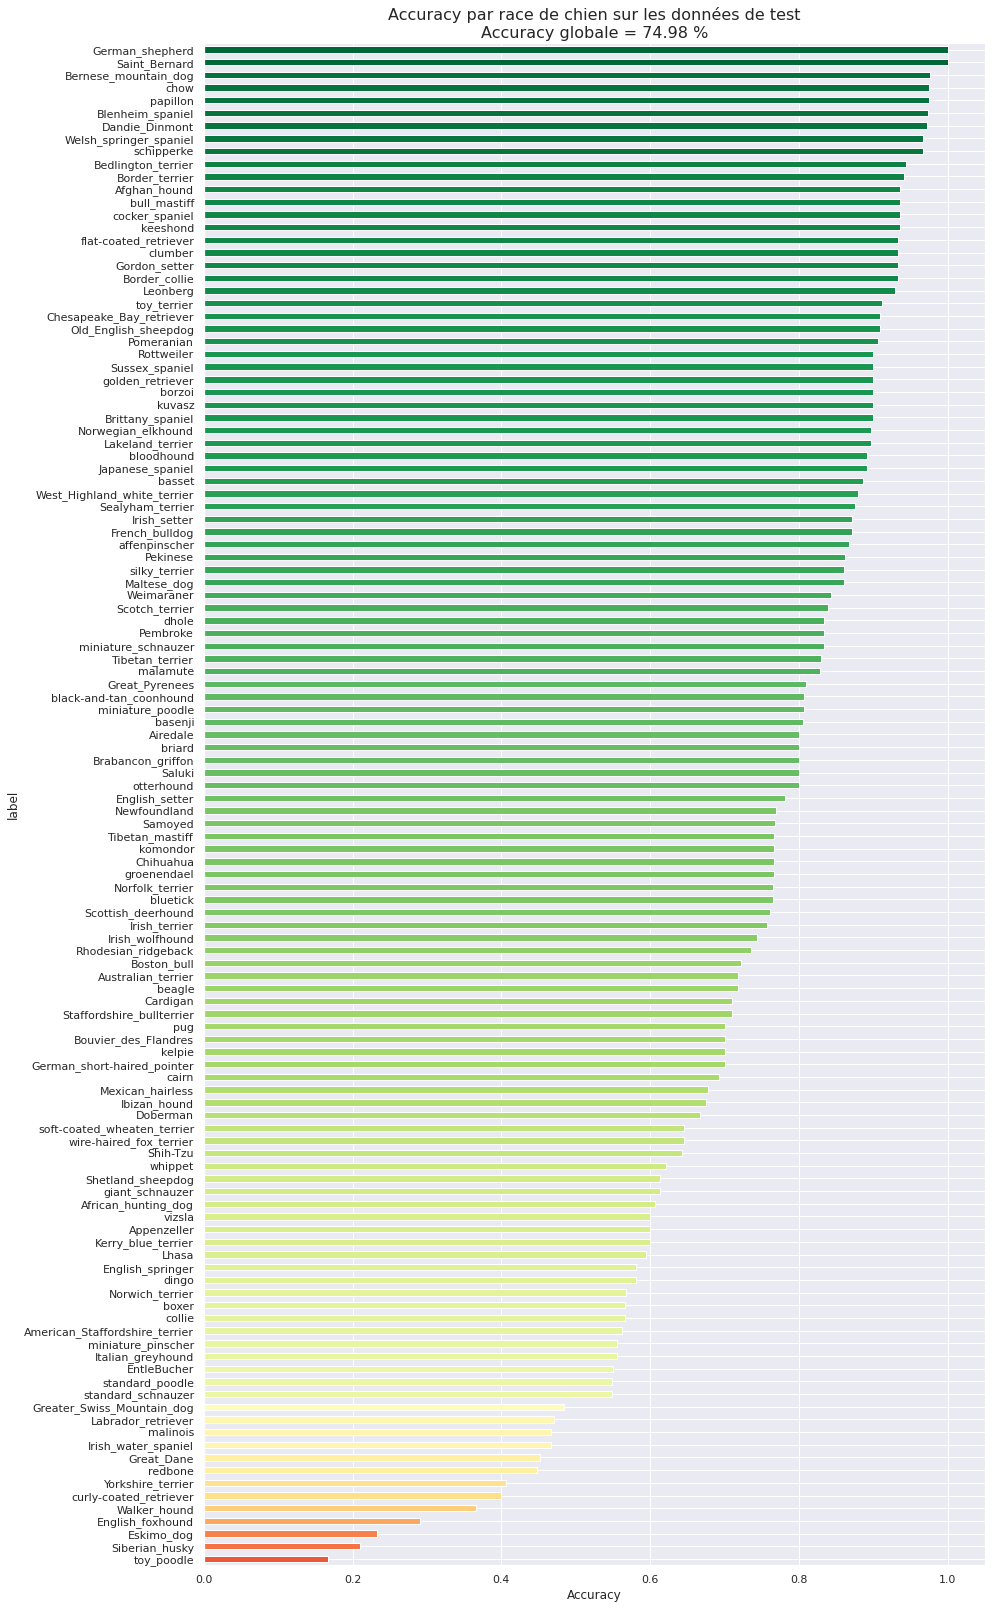

In [ ]:
df_results = accuracy_par_label(y_true_f, y_pred_f, dict_labels=validation_generator.class_indices)


In [ ]:
matrix = matrix_errors(y_true_f, y_pred_f, validation_generator.class_indices, display=False)

erreur_par_race(matrix, 'English_foxhound', validation_generator.class_indices)
erreur_par_race(matrix, 'Walker_hound', validation_generator.class_indices)


Erreurs English_foxhound : {'American_Staffordshire_terrier': 1, 'English_setter': 1, 'Greater_Swiss_Mountain_dog': 1, 'Walker_hound': 4, 'basset': 1, 'beagle': 13, 'bloodhound': 1}
Erreurs Walker_hound : {'English_foxhound': 1, 'Greater_Swiss_Mountain_dog': 1, 'Saint_Bernard': 1, 'Welsh_springer_spaniel': 2, 'basset': 6, 'beagle': 7, 'wire-haired_fox_terrier': 1}


In [ ]:
erreur_par_race(matrix, 'Eskimo_dog', validation_generator.class_indices)

Erreurs Eskimo_dog : {'Border_collie': 1, 'Cardigan': 1, 'German_shepherd': 2, 'Pembroke': 1, 'Siberian_husky': 3, 'malamute': 15}


In [ ]:
# Sauvegarde du dictionnaire des labels pour le programme :

dict_labels = {v:k for (k,v) in validation_generator.class_indices.items()}

with open(chemin2 + 'dict_labels', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump(dict_labels)


In [ ]:
(matrix_errors(y_true_f, y_pred_f, validation_generator.class_indices, display=False, aff_infos=False) != 0).sum()/120

# En moyenne pour une race donnée, les erreurs sont distribuées dans 4.4 autres races différentes.

4.433333333333334

# IV - Mon CNN

Après le transfer learning, nous passons au CNN créé et entrainé de A à Z.  
Pour notre CNN nous nous inspirons du VGG16, qui empile des blocs de convolution entre lesquels on place des couches de pooling qui divisent la taille de l'image / la carte d'activation par 2.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras import optimizers

## A - Sur les 10 races 1er choix

### ImageDataGenerator

In [ ]:
# # Chargement des images pour le fit du data_generator

# from keras.preprocessing.image import load_img

# directory = chemin + 'Images_selection_crop/'

# images = np.zeros(shape=(0,224,224,3))

# for race in os.listdir(directory):
#     for img in os.listdir(directory + race)[:20]:
#         images = np.concatenate((images, np.array([img_to_array(load_img(directory + race + '/' + img, target_size=(224,224)))])))


# images.shape

In [ ]:
from tensorflow.image import rgb_to_grayscale

image_size = 224
directory = chemin + 'Images_selection_crop/'
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=40,
                                    #samplewise_center=True,
                                    #width_shift_range=0.2,
                                    #height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='constant',
                                    validation_split=0.2)

#data_generator.fit(images)

train_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,  # max
        class_mode='categorical',
        shuffle=False,
        subset='validation')

# Fonction de preprocess testées :
# preprocessing_function=rgb_to_grayscale
# preprocessing_function=img_equalize
# preprocessing_function=lambda img: img_equalize(rgb_to_grayscale(img)) # pas mieux que 35%
# preprocessing_filter(ImageFilter.GaussianBlur(radius=2)) --> moyen comme attendu
# preprocessing_filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)) --> la fct de perte explose
# preprocessing_function=preprocessing_filter(ImageFilter.MedianFilter(size=3)) --> idem
# preprocessing_function=preprocessing_filter(ImageFilter.CONTOUR) --> idem
# preprocessing_function=preprocessing_filter(ImageFilter.EMBOSS) --> idem

# samplewise_std_normalization=True, --> ne donne rien du tout !
# featurewise_std_normalization=True --> idem
# featurewise_center=True --> idem
# samplewise_center=True --> pas de diff notable

Found 1484 images belonging to 10 classes.
Found 366 images belonging to 10 classes.


### Modèle

In [ ]:
from keras.optimizers import SGD, adagrad, adadelta, adam
from keras.layers import Dropout

num_classes = 10

mon_model = Sequential()

# Premier bloc de convolution
mon_model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#mon_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# Première couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Second bloc de convolution
#mon_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# Seconde couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Troisième bloc de convolution
#mon_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# Troisième couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 4ème bloc de convolution
#mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# 4ème couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 5ème bloc de convolution
#mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# 5ème couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

mon_model.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
mon_model.add(Dense(1024, activation='relu'))
mon_model.add(Dropout(0.8))

# Ajout de la dernière couche fully-connected qui permet de classifier
mon_model.add(Dense(num_classes, activation='softmax'))

mon_model.compile(optimizer=adam(), loss='categorical_crossentropy', metrics=['accuracy'])
mon_model.summary()


# 30 % d'Accuracy sur les données de test avec des groupes de convolution de 2 couches de 112x112x64 --> 7x7x64 + 2 couches dense 1024
# 44 % avec le preprocessing de VGG16
# Je n'ai pas mieux en augmentant le nombre d'entrées pour les couches fully-connected (2048)
# Je passe au-dessus de 50% avec de la data augmentation (horizontal_flip=True, rotation_range=20)
# Avec une égalisation en couleurs comme preprocessing la fonction de perte explose...
# Je plafonne à 36% en noir et blanc ()
# Pas de grosses différence entre 2, 3 et même une couche de convolution pour chaque bloc !


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

In [ ]:
# Sauvegarde des poids random initiaux pour reset les poids du modèle dans la session courante.
# mon_model.save_weights(chemin2 + 'mon_model_reset_weights')


In [ ]:
checkpoint_filepath = chemin2 + 'checkpoint_mon_model'

model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                            save_weights_only=True,
                                            save_best_only=True)

In [ ]:
recompute_model = False
Load_weights = True
Reset_weights = False

if recompute_model:

    if Load_weights:
        mon_model.load_weights(checkpoint_filepath)
    if Reset_weights:
        mon_model.load_weights(chemin2 + 'mon_model_reset_weights')

    # Model fit :
    fit_history  = mon_model.fit_generator(
            train_generator,
            epochs=50,
            validation_data=validation_generator,
            verbose=1,
            #callbacks=[model_checkpoint_callback]
            )


    # Save (history, y_true, y_pred) sur les données de validation :
    History = fit_history.history
    
    validation_generator.reset()
    pred = mon_model.predict_generator(validation_generator, verbose = 1)
    y_pred = np.argmax(pred, axis = 1)

    y_true = []
    for i in range(len(validation_generator)):
        y_true += list(np.argmax(validation_generator[i][1], axis=1))   

    model_results = (History, y_true, y_pred)

    with open(chemin2 + 'mon_model_results', 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(model_results)

else:
    with open(chemin2 + 'mon_model_results', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History, y_true, y_pred) = mon_depickler.load()



### Accuracy par race et affichage des erreurs

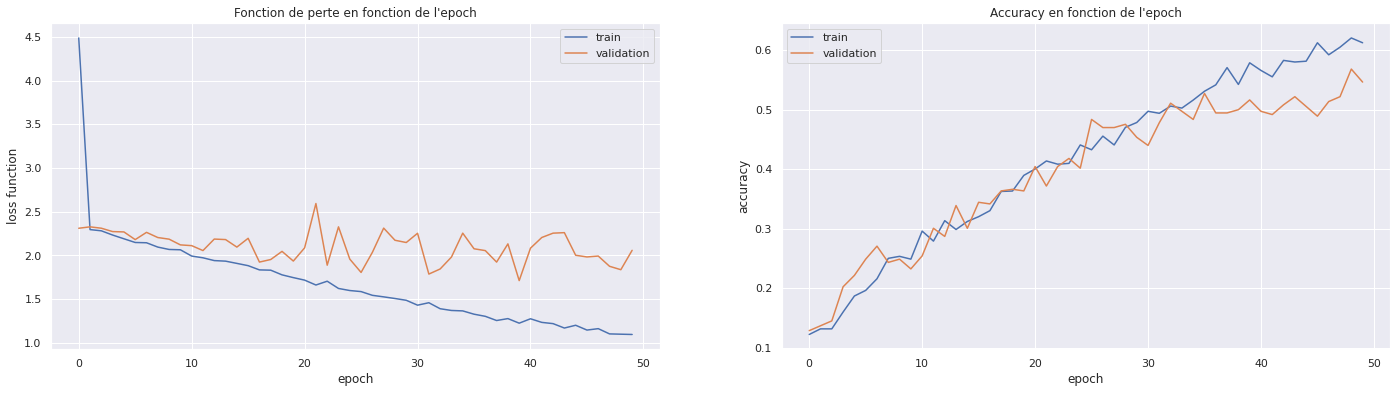

In [ ]:
# Accuracy sur les données de validation, en fonction de l'epoch


fig, ax = plt.subplots(1, 2, figsize = (24, 6))


ax[0].plot(History['loss'][:60])
ax[0].plot(History['val_loss'][:60])

ax[0].set_title('Fonction de perte en fonction de l\'epoch')  
ax[0].set_ylabel('loss function')  
ax[0].set_xlabel('epoch')  
ax[0].legend(['train', 'validation']) 

ax[1].plot(History['accuracy'][:60])
ax[1].plot(History['val_accuracy'][:60])

ax[1].set_title('Accuracy en fonction de l\'epoch')  
ax[1].set_ylabel('accuracy')  
ax[1].set_xlabel('epoch')  
ax[1].legend(['train', 'validation']) 

plt.show()

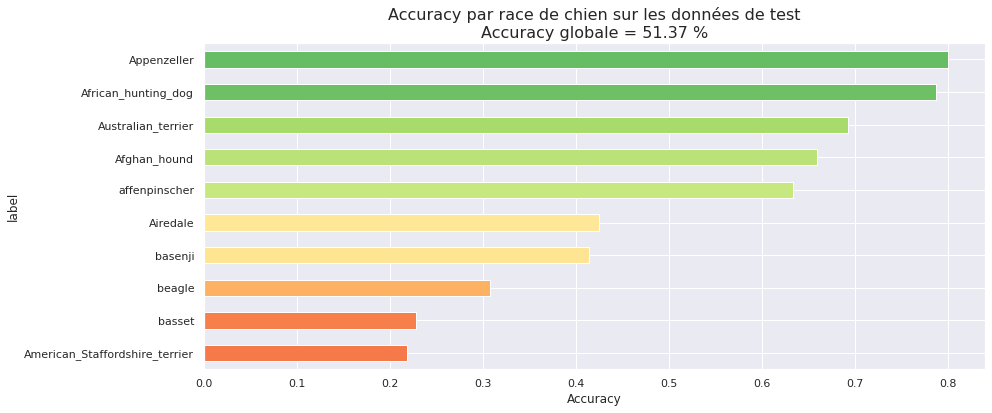

In [ ]:
df_results = accuracy_par_label(y_true, y_pred, dict_labels=validation_generator.class_indices)


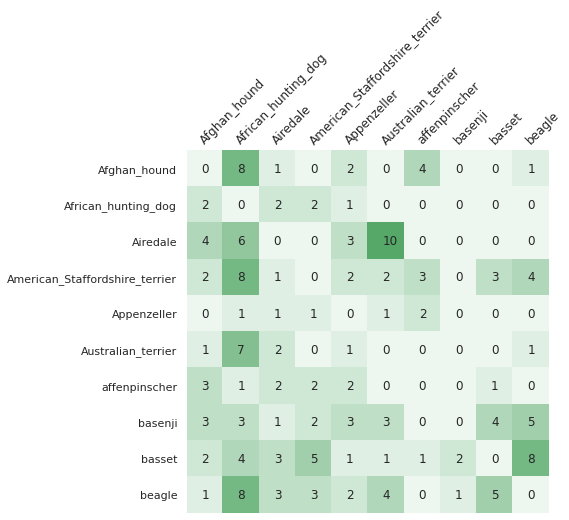

In [ ]:
matrix_errors(y_true, y_pred, validation_generator.class_indices)
print()

### Exemple de sur-apprentissage

On a enregistré les courbes des fonctions de pertes et de l'accuracy des données d'entrainement et de test en fonction du nombre d'époques lorque l'on utilise pas de data augmentation.  
Ces courbes illustrent l'overfitting.

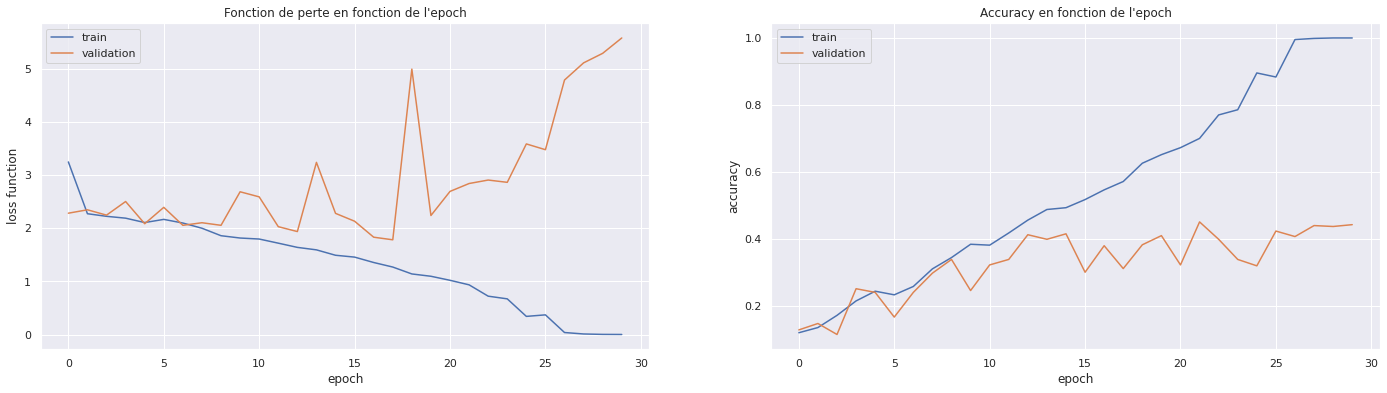

In [ ]:
with open(chemin2 + 'overfitting', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History, y_true, y_pred) = mon_depickler.load()

# Accuracy sur les données de validation, en fonction de l'epoch


fig, ax = plt.subplots(1, 2, figsize = (24, 6))


ax[0].plot(History['loss'][:30])
ax[0].plot(History['val_loss'][:30])

ax[0].set_title('Fonction de perte en fonction de l\'epoch')  
ax[0].set_ylabel('loss function')  
ax[0].set_xlabel('epoch')  
ax[0].legend(['train', 'validation']) 

ax[1].plot(History['accuracy'][:30])
ax[1].plot(History['val_accuracy'][:30])

ax[1].set_title('Accuracy en fonction de l\'epoch')  
ax[1].set_ylabel('accuracy')  
ax[1].set_xlabel('epoch')  
ax[1].legend(['train', 'validation']) 

plt.show()

## B - Sur les 10 races 2nd choix

On refait tourner le même CNN mais sur 10 races parmi celles qui ont les meilleurs résultats du transfer learning.

### ImageDataGenerator

In [ ]:

image_size = 224
directory = chemin + 'Images_selection_crop_3/'

data_generator = ImageDataGenerator(#preprocessing_function=preprocess_input,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='constant',
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,
        class_mode='categorical',
        subset='training')

validation_generator = data_generator.flow_from_directory(
        directory,
        target_size=(image_size, image_size),
        batch_size=100,  # max
        class_mode='categorical',
        shuffle=False,
        subset='validation')


Found 1520 images belonging to 10 classes.
Found 375 images belonging to 10 classes.


### Modèle

In [ ]:
from keras.optimizers import SGD, adagrad, adadelta, adam
from keras.layers import Dropout

num_classes = 10

mon_model = Sequential()

# Premier bloc de convolution
mon_model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#mon_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# Première couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Second bloc de convolution
#mon_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# Seconde couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Troisième bloc de convolution
#mon_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# Troisième couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 4ème bloc de convolution
#mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# 4ème couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# 5ème bloc de convolution
#mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
mon_model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
# 5ème couche de pooling
mon_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

mon_model.add(Flatten())  # Conversion des matrices 3D en vecteur 1D

# Ajout de la première couche fully-connected, suivie d'une couche ReLU
mon_model.add(Dense(1024, activation='relu'))
mon_model.add(Dropout(0.8))

# Ajout de la dernière couche fully-connected qui permet de classifier
mon_model.add(Dense(num_classes, activation='softmax'))

mon_model.compile(optimizer=adam(), loss='categorical_crossentropy', metrics=['accuracy'])
mon_model.summary()



Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 56, 56, 256)      

In [ ]:
recompute_model = False

if recompute_model:

    # Model fit :
    fit_history  = mon_model.fit_generator(
            train_generator,
            epochs=100,
            validation_data=validation_generator,
            verbose=1,
            )

    # Save (history, y_true, y_pred) sur les données de validation :
    History = fit_history.history
    
    validation_generator.reset()
    pred = mon_model.predict_generator(validation_generator, verbose = 1)
    y_pred = np.argmax(pred, axis = 1)

    y_true = []
    for i in range(len(validation_generator)):
        y_true += list(np.argmax(validation_generator[i][1], axis=1))   

    model_results = (History, y_true, y_pred)

    with open(chemin2 + 'mon_model_results_2', 'wb') as fichier:
        mon_pickler = pickle.Pickler(fichier)
        mon_pickler.dump(model_results)

else:
    with open(chemin2 + 'mon_model_results_2', 'rb') as fichier:
        mon_depickler = pickle.Unpickler(fichier)
        (History, y_true, y_pred) = mon_depickler.load()



### Accuracy par race et affichage des erreurs

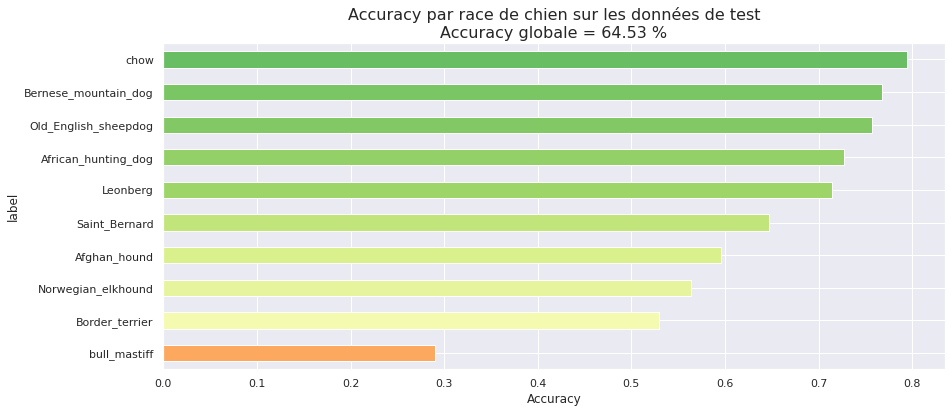

In [ ]:
df_results = accuracy_par_label(y_true, y_pred, dict_labels=validation_generator.class_indices)


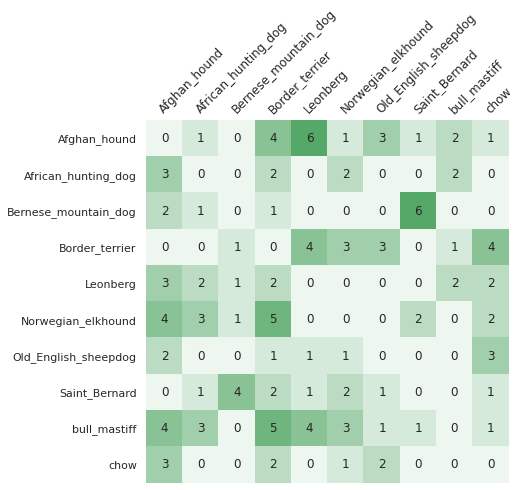

In [ ]:
matrix_errors(y_true, y_pred, validation_generator.class_indices)
print()